In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('data/sum_control_normalized_gaussian_smooth_trimmed_ATAC_bin_rm.csv', 'data/all_samples_normalized_gaussian_smooth_trimmed.csv', "input_train_data_trim" = 'data/sum_control_normalized_gaussian_smooth_trimmed_ATAC_bin_rm.csv', "input_test_data_trim" = 'data/all_samples_normalized_gaussian_smooth_trimmed.csv'),
    output = list('data/ATAC_predictions_on_all_samples_NEW/ATAC_pred_lasso_std_TRUE_gaussian_trimmed.csv', 'Trained_models/On_summed_controls/Lasso_models/lasso_std_TRUE_gaussian_trimmed.rds', "output_pred" = 'data/ATAC_predictions_on_all_samples_NEW/ATAC_pred_lasso_std_TRUE_gaussian_trimmed.csv', "output_model" = 'Trained_models/On_summed_controls/Lasso_models/lasso_std_TRUE_gaussian_trimmed.rds'),
    params = list(),
    wildcards = list(),
    threads = 1,
    log = list('logs/processed_notebooks/processed_Smooth_gaussian_10_Lasso_reg_TRUE_Discard.r.ipynb', "notebook" = 'logs/processed_notebooks/processed_Smooth_gaussian_10_Lasso_reg_TRUE_Discard.r.ipynb'),
    resources = list('mem_mb', 'disk_mb', 'tmpdir', 'time', "mem_mb" = 50000, "disk_mb" = 56872, "tmpdir" = '/scratch/55672201', "time" = '06:00:00'),
    config = list(),
    rule = 'model_lasso_trimming',
    bench_iteration = as.numeric(NA),
    scriptdir = '/faststorage/project/DELFI1/Workspaces/CarmenAndAnika/ATAC_pred_models/Lasso_regression',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/faststorage/project/DELFI1/Workspaces/CarmenAndAnika');

######## snakemake preamble end #########


# Lasso regression on data smoothed with Gaussian (n = 10)

In [2]:
library(tidyverse)

#install.packages('scales')
#library(scales)

install.packages("slider")
library(slider)

library(glmnet)



Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.

In [3]:
#sum_control_ATAC_bin_rm_gaussian_mean <- read.csv("../../data/sum_control_normalized_gaussian_smooth_trimmed_ATAC_bin_rm.csv")
sum_control_normalized_gaussian_trimmed <- read.csv(snakemake@input[["input_train_data_trim"]])
ATAC_val <- sum_control_normalized_gaussian_trimmed %>% select(ATAC_val)
head(ATAC_val)
sum_control_normalized_gaussian_trimmed = sum_control_normalized_gaussian_trimmed %>% select(-ATAC_val)

head(sum_control_normalized_gaussian_trimmed)

ATAC_val
0.5931657
0.4089315
0.3058228
0.4764137
0.2862775
0.3169988


X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
1.941075e-05,2.079943e-05,2.162218e-05,2.244632e-05,2.353735e-05,2.524666e-05,2.846163e-05,3.416138e-05,4.175699e-05,5.068301e-05,...,7.706825e-05,7.389605e-05,7.064061e-05,6.691617e-05,6.300203e-05,5.890176e-05,5.505384e-05,5.169955e-05,4.846250e-05,4.546832e-05
3.340475e-05,3.604897e-05,3.813424e-05,3.972881e-05,4.136925e-05,4.373924e-05,4.763574e-05,5.387640e-05,6.273863e-05,7.350752e-05,...,1.025889e-04,9.652966e-05,9.020873e-05,8.499570e-05,8.022667e-05,7.591143e-05,7.223015e-05,6.880952e-05,6.539239e-05,6.217557e-05
1.827843e-05,1.906753e-05,1.961684e-05,2.002694e-05,2.043854e-05,2.184018e-05,2.401005e-05,2.806282e-05,3.377775e-05,4.125139e-05,...,9.849611e-05,9.453006e-05,9.032740e-05,8.597152e-05,8.156974e-05,7.759355e-05,7.430006e-05,7.126369e-05,6.859701e-05,6.604890e-05
1.889019e-05,2.052863e-05,2.166710e-05,2.231962e-05,2.285308e-05,2.389903e-05,2.591130e-05,2.996872e-05,3.643993e-05,4.400150e-05,...,8.055576e-05,7.566216e-05,7.139018e-05,6.710408e-05,6.303360e-05,5.923884e-05,5.550531e-05,5.198491e-05,4.928195e-05,4.691004e-05
1.210448e-05,1.325520e-05,1.430822e-05,1.507180e-05,1.577416e-05,1.690351e-05,1.881520e-05,2.241909e-05,2.754345e-05,3.405389e-05,...,8.814493e-05,8.331454e-05,7.885015e-05,7.475785e-05,7.066735e-05,6.703360e-05,6.344876e-05,6.032220e-05,5.786202e-05,5.525848e-05
1.368989e-05,1.531414e-05,1.667634e-05,1.768305e-05,1.861072e-05,2.007812e-05,2.246905e-05,2.612024e-05,3.174561e-05,3.872263e-05,...,8.687011e-05,8.273963e-05,7.837361e-05,7.445714e-05,7.078112e-05,6.741255e-05,6.405234e-05,6.083425e-05,5.773046e-05,5.479946e-05


## Finding the best lambda

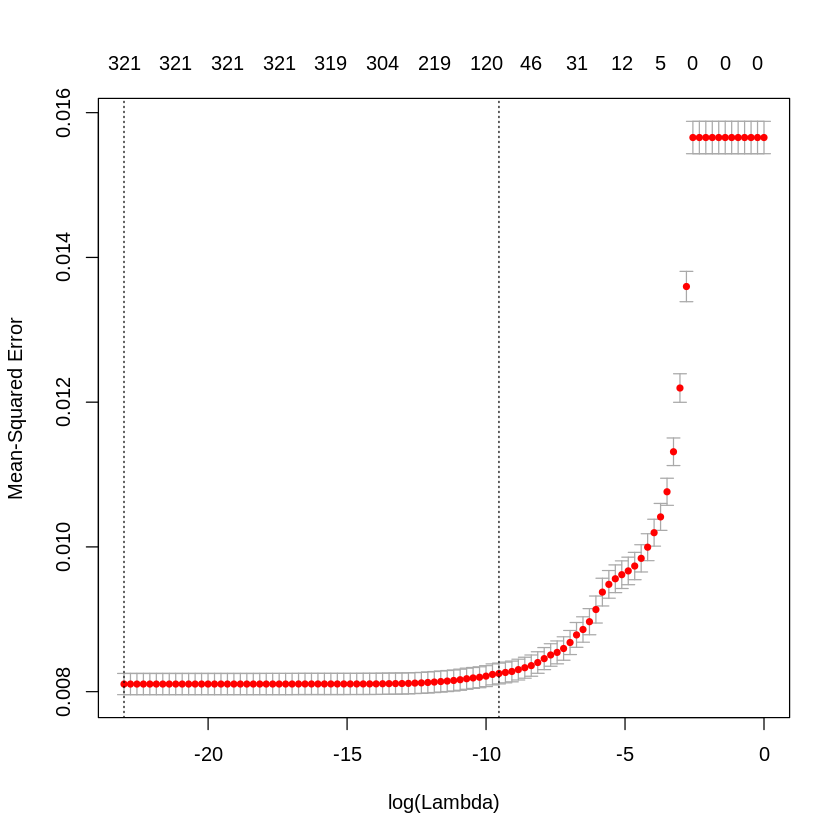

In [4]:
set.seed(0)
#X==predictor
#y==response

y <- ATAC_val %>% as.matrix()
X <- sum_control_normalized_gaussian_trimmed %>% as.matrix()

lambdas_to_try <- 10^seq(-10, 0, length.out = 100)
#standardize = FALSE -- range -12, -3
#standardize = TRUE -- range -10, 0


lasso_smooth_cv <- cv.glmnet(X, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(lasso_smooth_cv)

In [5]:
(lambda_smooth_cv <- lasso_smooth_cv$lambda.min)

[1] 1e-10

In [6]:
CV_lasso_smooth<-function(data, nfolds){
    set.seed(0)
    cvfolds <- cut(1:nrow(data), breaks = nfolds, labels = F)
    cvfolds <- sample(cvfolds)
    

    predicted <- rep(NA, nrow(data))
    #data_as_matrix <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    y <- ATAC_val %>%  as.matrix()
    X <- sum_control_normalized_gaussian_trimmed %>% as.matrix()
    
    for (i in 1:nfolds){
        rows      <- which(cvfolds==i)
        testdata  <- X[rows,]
        traindata <- X[-rows,]
        train_y <- y[-rows,]

        fit       <- glmnet(traindata, train_y, alpha = 1, lambda = lambda_smooth_cv, standardize = TRUE)
        tmp       <- predict(fit, s=lambda_smooth_cv, testdata)
        predicted[rows] <- tmp
    }
    
    rm(tmp)
    observed <- y
    head(observed)
    mean(observed)
    se    <- (observed-predicted)^2
    mse   <- mean(se)
    (rmse <- sqrt(mse))
    
    return(tibble(observed = observed, predicted = predicted))
}

In [7]:
res_lasso_smooth_gaussian_pred <- CV_lasso_smooth(sum_control_normalized_gaussian_trimmed, 10)

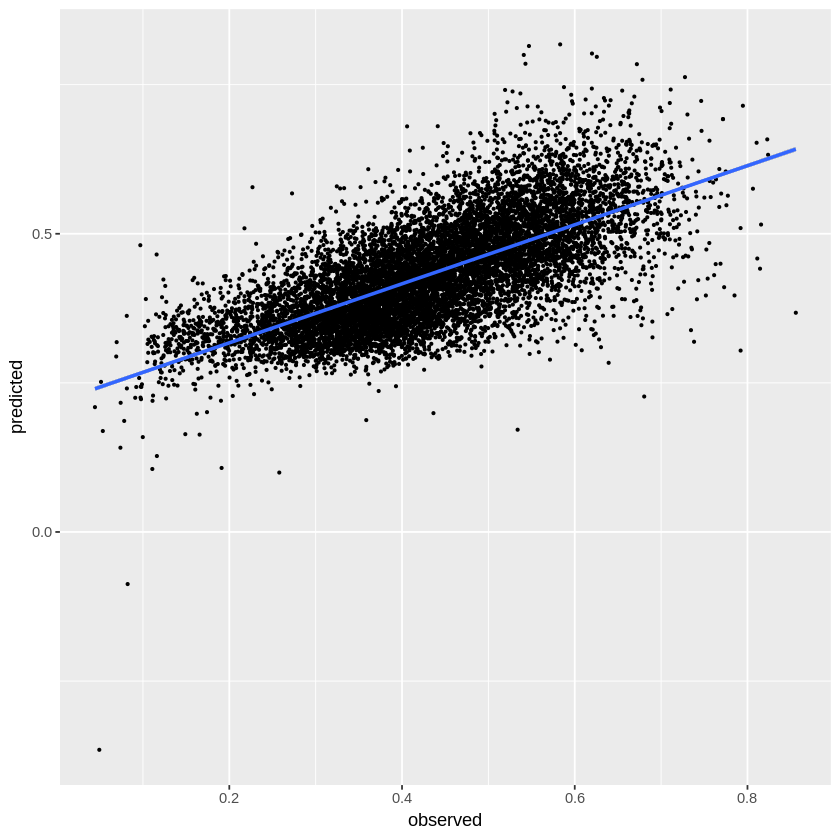

In [8]:
ggplot(res_lasso_smooth_gaussian_pred, aes(x = observed, y = predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [9]:
cor(res_lasso_smooth_gaussian_pred$observed, res_lasso_smooth_gaussian_pred$predicted)

# Standardize = TRUE: ATAC_val 0.6929081
# Standardize = FALSE: ATAC_val 

ATAC_val,0.6929081


In [10]:
y <- ATAC_val %>% as.matrix()
X <- sum_control_normalized_gaussian_trimmed %>% as.matrix()

fit       <- glmnet(X, y, alpha = 1, lambda = lambda_smooth_cv, standardize = TRUE)
saveRDS(fit, snakemake@output[["output_model"]])

#tmp       <- predict(fit, s=lambda_smooth_cv, testdata)

Normalization and predictions

In [11]:
#filename = "data/all_samples_normalized_trimmed.csv"
filename = snakemake@input[["input_test_data_trim"]]

In [12]:
small_test <- read_csv(file = filename, col_names = T, comment = "#", skip = 0, n_max = 20)
head(small_test)

Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.


sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
PGDX10344P1,chr10_400,2.635648e-05,2.551240e-05,3.041764e-05,3.743369e-05,4.529382e-05,7.822038e-05,1.088130e-04,1.352074e-04,...,0.0002692328,0.0002645551,0.0002411552,0.0002046561,0.0001627598,1.337986e-04,0.0001030308,9.631365e-05,9.505189e-05,1.074471e-04
PGDX10344P1,chr10_40,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.063345e-06,1.461970e-05,3.128720e-05,5.500537e-05,...,0.0001944052,0.0001867330,0.0001802170,0.0001743696,0.0001920661,1.991633e-04,0.0002152961,2.191585e-04,2.233594e-04,2.137830e-04
PGDX10344P1,chr10_4,5.872179e-05,5.289260e-05,5.340677e-05,5.454810e-05,6.798495e-05,7.621979e-05,8.256314e-05,9.338255e-05,...,0.0002578428,0.0002614286,0.0002683933,0.0002580492,0.0002405518,2.035011e-04,0.0001702625,1.276962e-04,9.172705e-05,7.422905e-05
PGDX10344P1,chr10_401,8.180537e-05,8.398114e-05,8.175570e-05,8.748995e-05,9.207371e-05,9.639651e-05,1.133106e-04,1.224668e-04,...,0.0002087284,0.0001672440,0.0001206191,0.0000962458,0.0000869615,9.938756e-05,0.0001326077,1.601019e-04,1.795923e-04,1.772339e-04
PGDX10344P1,chr10_402,1.476717e-05,2.345811e-05,4.079304e-05,5.457810e-05,6.599014e-05,7.245930e-05,8.060398e-05,8.075730e-05,...,0.0004394529,0.0004394405,0.0004194749,0.0003816848,0.0003506651,3.193917e-04,0.0002856203,2.735742e-04,2.720397e-04,2.660698e-04
PGDX10344P1,chr10_403,6.067274e-05,8.155138e-05,9.276169e-05,9.578039e-05,1.061449e-04,1.155964e-04,1.242783e-04,1.345972e-04,...,0.0001596542,0.0001474896,0.0001478111,0.0001549740,0.0001742598,2.056872e-04,0.0002243287,2.385956e-04,2.456770e-04,2.395614e-04


In [13]:
cols_predictions = as.data.frame(t(c("sample", "bin", "ATAC_prediction")))


In [14]:
# Initiate the empty file and add column names

write.table(NULL, file=snakemake@output[["output_pred"]], 
             append = F, 
             sep=',', 
             row.names=F, 
             col.names=F)

#colnames_pred <- c("sample", "bin", "ATAC_prediction")

write.table(cols_predictions, snakemake@output[["output_pred"]], append = F, sep=',', col.names=F, row.names=F)

In [15]:
f <- function(df1, pos) {
    df1[3:323] <- lapply(df1[3:323], as.numeric)
    
    df <- df1 %>% select(-c("sample", "bin")) %>% as.matrix()
    tmp       <- as.vector(predict(fit, s=lambda_smooth_cv, df))
    
    tmp <- tibble(sample = df1$sample, bin = df1$bin, ATAC_prediction = tmp)
    #message(tmp)
    write.table(tmp, snakemake@output[["output_pred"]], append = TRUE, sep=',', col.names=F, row.names=F)

}

df <- read_delim_chunked(file = filename, 
                 callback = DataFrameCallback$new(f), 
                 chunk_size = 10000, col_names = T,
                 delim = ",", 
                 progress = show_progress())


Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.
